# A Reservoir of Timescales in Random Neural Network

This notebook is associated with the following [article](https://arxiv.org/abs/2110.09165).

Underneath you can find a summary of the main results.

In [1]:
%%HTML
<iframe width="840" height="472.5" 
src="https://www.youtube.com/embed/Ab8kJYdnVBI" 
title="YouTube video player" frameborder="0" 
allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" 
allowfullscreen></iframe>

We consider a population based rate model of a neural network. Our model consists of $N$ clusters of neurons. Mathematically, each cluster can be represented as a localized continuous variable $Q_{i}$, $i=1,2, ... ,N$ ranging between $Q_i(t) \in \left[-1.0,  1.0\right]$. Each cluster is associated with a local field $x_i(t)$ such that $Q_i(t) = \phi \left[ x_i(t) \right]$, where $\phi$ is an activation function that defines the input-output relationship for each cluster. Our model assumes a sigmoid shape activation function, we chose  $\phi\left[ \cdot \right] \equiv \tanh\left[ \cdot \right]$.
Biologically, $x_{i}(t)$ can be interpreted as the mean cluster activity, also known as the firing rate or population activity. The cluster properties are represented by a self-coupling term $s_i$  

The network is represented by a set of $N$ coupled ordinary differential equations:
$$
\frac{d}{dt}x_{i}(t) = - x_{i}(t) + s_i \phi \left[ x_i(t) \right]  + \sum_{i=1}^{N} J_{ij} \phi \left[ x_j(t) \right],
$$
the random couplings $J_{ij}$ from unit $j$ to unit $i$ are drawn independently from a Gaussian distribution with mean $0$ and variance $g^2/N$ where $g$ represents the network gain.
If we imagine a cluster of neurons as an electrical element. The left hand side describes the average change in the potential, the first term on the right hand side describes the average current leakage through the membrane of neurons, the second terms describes the average current due to the activity of neurons in the cluster scaled by a self-coupling parameter $s_i$ proportional to the number of neurons in the cluster. The last term on the right hand side describes the average current due to the activity of all other clusters. 

It is important to notice that the form of our coupled ODEs implies that time is a dimensionless parameter. In this model, we are using a homogeneous time constant $\theta_i = 1$ ms for all clusters.

Using [standard methods of statistical field theory](https://link.springer.com/book/10.1007/978-3-030-46444-8?noAccess=true), in the limit of large $N$ we can average over realizations of the disordered couplings $J_{ij}$ to derive a set of self-consistent dynamic mean field equations for each population of units $x_\alpha$ with self-coupling strengths $s_{\alpha} \in S$
\begin{equation}
\label{dmfteq1}
    \frac{dx_{\alpha}}{dt}=-x_{\alpha}+s_{\alpha}\tanh(x_{\alpha})+\eta(t)\ .
\end{equation}
In our notation, $S$ denotes the set of different values of self-couplings $s_\alpha$, indexed by $\alpha\in A$, and we denote by $N_\alpha$ the number of units with the same self-coupling $s_\alpha$, and accordingly by $n_\alpha=N_\alpha \big{/} N$ their fraction. The mean field $\eta(t)$ is the same for all units and has zero mean $\langle \eta(t)\rangle=0$ and autocorrelation

\begin{eqnarray}
    \langle \eta(t)&\eta&(t+\tau)\rangle=g^2C(\tau)\nonumber\\
    C(\tau)&=&\sum_{\alpha\in A } n_{\alpha} \langle \phi[x_{\alpha}(t)]\phi[x_{\alpha}(t+\tau)]\rangle \ ,     
    \label{dmfteq2}
\end{eqnarray}

where $\langle\cdot\rangle$ denotes an average over the mean field. 

When considering the large $N$ limit, that is a network with a large number of clusters, we simplified the large system to $card(S)$ ODEs that share a common term $\eta(t)$. This term can be thought of as the meanfield  background noise due to all the clusters. The dynamics described by each of these meanfield ODEs has its own autocorrelation function.

This result indicates that a total of $card(S)$ timescales are present in our network. We quantify the timescale as the Width at Half Max of the autocorelation function $\left< \phi(t)\phi(t+\tau) \right>$. The separatio $n_{\alpha}$ for each subpopulation.

## Importing Packages

In [8]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import odeint

from rnn_library import rnn_functions as rnn # importing local package as rnn
                                             # for details see rnn_functions.py file in rnn_libary folder 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)

## Defining the Network Dynamics

In [3]:
def NL_DifEq(x,t):
    """
    NL_DifEq specifies the set of ODE's that need to be solved.
    Applied within odeint. For more details look into scipy.integrate.odeint
    
    Note that the self coupling terms are the diagonal elemets of the coupling matirx J. 

    Requierements:
    
    x         -   initial value satisfied by Initial_Condition.
    t         -   timeline satsfied by 
    
    Output:
    
    dxdt     -   the change in the dynamic network variable x
    """
    
    dxdt = - x + J_Matrix @ np.tanh(x) 
    
    return dxdt

## Parameters

### Network Parameters

In [4]:
'''
In this cell we ask the user to specify 
the network parameters:
g, K, N_values, s_values
'''

# We consider a network with 
# 750 clusters with selfcoupling 1.0 and 
# 750 clusters with selfcoupling 3.0

N_values = [750, 750]       # stores number of clusters for each population
s_values = [1.0, 3.0]       # stores values of self-coupling each cluster population

K = len(N_values)           # stores the total number of unique clusters; number of subpopulations     
N = int(np.sum(N_values))   # stores total number of clusters in the network

# Specifying the network connectivity matrix J

# J is extracted from a normal distribution with mean 0 and variance g/sqrt(N)

g = 2.0                                              # gain parameter in the network; datatype float
mean  = 0.0                                          # mean of the Gaussian distribution
variance  = g/np.sqrt(N)                             # variance of the Gaussian distribution
J_Matrix = variance * np.random.randn(N**2) + mean   # returns an array of size N*N
J_Matrix = J_Matrix.reshape(N,N)                     # reshaping the array into a NxN matrix

# Specifying the diagonal elements of the J matrix

# (not an elegant solution, but it works)

diagonal = np.ones(N)
temp_pos_var = 0 

for idx in range(K):
    range_start = int(temp_pos_var)
    range_end = int(temp_pos_var+N_values[idx])
    
    diagonal[range_start:range_end] = diagonal[range_start:range_end]* s_values[idx]
    
    temp_pos_var = temp_pos_var + N_values[idx]
    
    
for cluster in range(N):
    J_Matrix[cluster][cluster] = diagonal[cluster]

### Simulation Parameters

In [5]:
# Specifying the timeline for solving the coupled ODEs

t_end = 2000.0                        # end of time  
dt = 0.1                              # timestep
timeline = np.arange(0, t_end, dt)    # stores time values t0 = 0, t1= 0.1, ....

# Specifying the timeline for the autocorrelation funcion (ACF)

steps_ignore = 500                             # minimum value 1 (see how the ACF is computed)
Tau_Steps = int((t_end*(1/dt)-steps_ignore))   # total number of steps for the ACF timeline
tau_timeline = np.arange(0,Tau_Steps,1.0)*dt   # stores time values t0 = 0, t1= 0.1, ....

# Specifying the initial conditions x(t = 0)
Initial_Condition = np.random.uniform(-2,2, N) # N size array from uniform distr. ranging from -2 to 2

## Running the Simulation

In [9]:
# Solving the system of coupled ODE with the specified parameters

x = odeint(NL_DifEq, Initial_Condition, timeline).T

# Solving for the ACF < phi[x(t)] phi[x(t+tau)] > ; phi[x] = tanh[x]

C_phi   = tfp.stats.auto_correlation(np.tanh(x[:,steps_ignore:]), axis =-1, max_lags = Tau_Steps, center = False, normalize = True)

# Averaging the ACF per cluster population
C_phi_avg = []

# stores the average HWHM per population  
timescales = []

temp_pos_var = 0 # not an elegant solution, but it works
for idx in range(K):
    range_start = int(temp_pos_var)
    range_end = int(temp_pos_var+N_values[idx])
    
    C_phi_avg.append(np.mean( C_phi[range_start:range_end] , axis = 0))
    
    temp_pos_var = N_values[idx]

    timescales.append(rnn.FWHM_funct(tau_timeline , C_phi_avg[idx]))

## Plotting Results

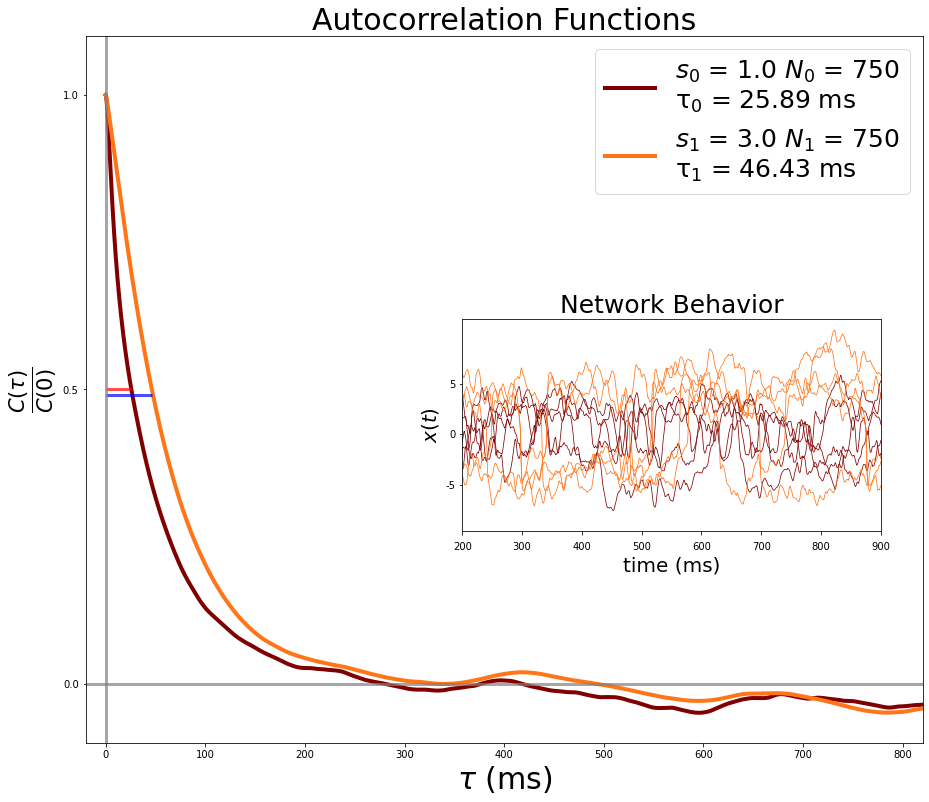

In [10]:
color_list = ['#800000', '#FF7518', '#FFDF00', '#8DB600', '#89CFF0', '#FFC0CB']
color_list_1 = ['red','blue', 'green', 'purple', 'gold']

fig, ax1 = plt.subplots(figsize = (15, 13))

##############################################################
####### ACF

for idx in range(K):
    ax1.plot(tau_timeline, C_phi_avg[idx], linewidth = 4, color = color_list[idx], 
             label = f'$s_{idx}$ = {s_values[idx]} $N_{idx}$ = {N_values[idx]}\n\u03C4$_{idx}$ = {np.round(timescales[idx],2)} ms')
    ax1.hlines(0.50-0.01*idx, 0, timescales[idx], color = color_list_1[idx], linewidth = 3, alpha  = 0.7)
    
ax1.hlines(0, -100, Tau_Steps*dt, color = 'gray', linewidth = 3, alpha  = 0.7)
ax1.vlines(0, -0.5, 1.5, color = 'gray', linewidth = 3, alpha  = 0.7)

ax1.legend(loc=0, fontsize = 25)

ax1.set_xlabel(r'$\tau$ (ms)', fontsize = 30)
ax1.set_ylabel(r'$\frac{C(\tau)}{C(0)}$', fontsize = 30)

##############################################################
####### Behavior

num_samples = 5

ranges = []
for i in range(K,-1,-1):
    ranges.append(N - np.sum( N_values[ : i] ) )

neuron_idx = []
for i in range(K):
    neuron_idx.append(np.random.randint(ranges[i], ranges[i+1], num_samples))

# Create a set of inset Axes: these should fill the bounding box allocated to
# them.
ax2 = plt.axes([0,0,1,1])
# Manually set the position and relative size of the inset axes within ax1
ip = InsetPosition(ax1, [0.45,0.3,0.5,0.3]) #left bottom width height
ax2.set_axes_locator(ip)


# The data: only display for low temperature in the inset figure.
for i in range(K):
    ax2.plot(timeline, x[neuron_idx[i][0]], color = color_list[i], linewidth = 0.75)
    for j in range(1, num_samples): 
        ax2.plot(timeline, x[neuron_idx[i][j]], color = color_list[i] , linewidth = 0.75)

ax2.set_xlabel(r'time (ms)', fontsize = 20)
ax2.set_ylabel(r'$x(t)$', fontsize = 20)

# Some ad hoc tweaks.
ax1.set_xlim(-20,820)
ax1.set_ylim(-0.1,1.1)

ax1.set_yticks([0, 0.5, 1])
ax1.set_yticklabels(ax1.get_yticks(), backgroundcolor='w')

# behavior time range
timeline_start = 200
timeline_end   = 900 
ax2.set_xlim(timeline_start, timeline_end)

ax2.set_xticks(np.arange( timeline_start , timeline_end+1 ,100))
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w')
ax2.set_yticks([-5, 0, 5])
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor='w')
ax2.tick_params(axis='x', which='major', pad=8)

ax1.set_title("Autocorrelation Functions", fontsize = 30)
ax2.set_title("Network Behavior", fontsize = 25)

plt.show()